In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from pathlib import Path

In [2]:
DATA_DIR = Path.home()/Path('shared/climate-data')

co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [9]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

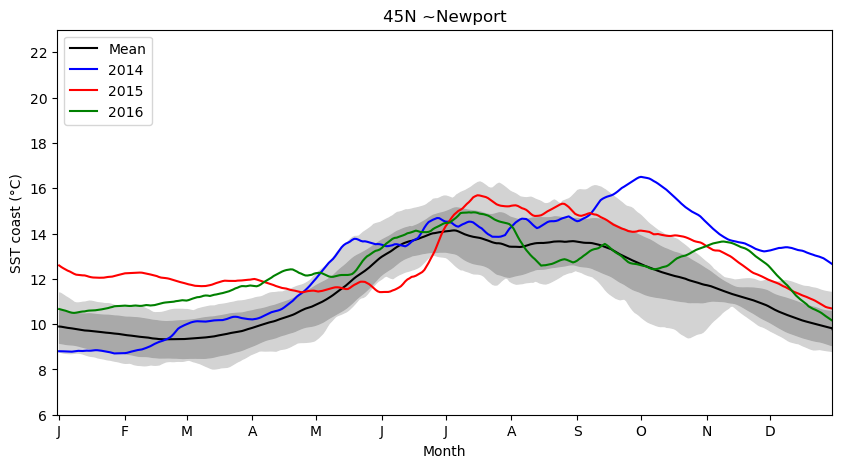

In [33]:
# slice data for the Newport and convert to Celsius
newport = ds.analysed_sst.sel(lat = 45, lon = -124, method = 'nearest') - 273.15

# take rolling mean
newport = newport.rolling(time = 30, center = True).mean()

# create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# slice year 2002-2013 and grouped
ds2002 = newport.sel(time = slice('2002', '2013')).groupby('time.dayofyear')

# get max, min, mean, std, and upper/lower bounds
maximum = ds2002.max()
minimum = ds2002.min()
mean = ds2002.mean()
std = ds2002.std()
upper = mean + std
lower = mean - std

# plot mean data from 2002-2013
ax.plot(mean.dayofyear.values, mean, 'k', label='Mean')

# plot shaded areas for maximum and minimum 
ax.fill_between(mean.dayofyear.values, minimum, maximum, color='lightgray')

# plot shaded area between lower and upper bound
ax.fill_between(mean.dayofyear.values, lower, upper, color='darkgray')

# plot smoothed time series for 2014, 2015, and 2016
ds2014 = newport.sel(time = '2014').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'b', label = '2014')
ds2015 = newport.sel(time = '2015').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'r', label = '2015')
ds2016 = newport.sel(time = '2016').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'g', label = '2016')

# labeling x-axis with months
plt.xticks([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336], 
           ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])  

ax.legend(loc = 'upper left')
plt.ylim(6, 23)
plt.xlim(0, 365)
plt.ylabel('SST coast (°C)')
plt.xlabel('Month')
plt.title('45N ~Newport')
plt.show()